# Trading Challenge: SMA Crossover Strategy with ATR-based Risk Management
## Objective: Implement a complete trading system with dynamic risk management and performance analysis

### Challenge Requirements:
- **Instrument**: EUR/USD (high liquidity, beginner-friendly)
- **Timeframe**: 15 minutes (balanced data points, reduced noise)
- **Strategy**: SMA crossover with last 100 candles
- **Execution**: Market orders on signals
- **Risk Management**: Dynamic Stop-loss/take-profit based on ATR(14)
- **Analysis**: Win rate, P/L, drawdown, Sharpe ratio

In [14]:
# Setup and imports
import pandas as pd
from ib_async import *
import numpy as np
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt  # pyright: ignore[reportMissingImports]
import warnings
warnings.filterwarnings('ignore')

util.startLoop()
ib = IB()
ib.connect()

<IB connected to 127.0.0.1:7497 clientId=1>

In [15]:
# 1. Select Instrument - EUR/USD
contract = Forex("EURUSD")
ib.qualifyContracts(contract)
print(f"Trading instrument: {contract}")
contract

Trading instrument: Forex('EURUSD', conId=12087792, exchange='IDEALPRO', localSymbol='EUR.USD', tradingClass='EUR.USD')


Forex('EURUSD', conId=12087792, exchange='IDEALPRO', localSymbol='EUR.USD', tradingClass='EUR.USD')

In [16]:
# 2. Define timeframe and fetch last 100+ candles for SMA and ATR calculation
def get_historical_data(contract, bars_needed=120):
    """Fetch 15-min historical data for SMA/ATR calculation"""
    data = ib.reqHistoricalData(
        contract, 
        "", 
        barSizeSetting="15 mins", 
        durationStr="2 D",  # 2 days to ensure we get enough bars
        whatToShow="MIDPOINT", 
        useRTH=False,  # Include after-hours for Forex
        formatDate=2
    )
    df = util.df(data)
    return df.tail(bars_needed)  # Keep only last 120 bars

# Initial data fetch
df = get_historical_data(contract)
print(f"Fetched {len(df)} bars of 15-minute EUR/USD data")
print(f"Date range: {df.date.min()} to {df.date.max()}")
df.tail()

Fetched 120 bars of 15-minute EUR/USD data
Date range: 2025-12-04 15:15:00+00:00 to 2025-12-05 21:15:00+00:00


,date,open,high,low,close,volume,average,barCount
183,2025-12-05 20:15:00+00:00,1.164300,1.164325,1.164030,1.164155,-1.0,-1.0,-1
184,2025-12-05 20:30:00+00:00,1.164155,1.164340,1.164070,1.164245,-1.0,-1.0,-1
185,2025-12-05 20:45:00+00:00,1.164245,1.164460,1.163985,1.164410,-1.0,-1.0,-1
186,2025-12-05 21:00:00+00:00,1.164410,1.164720,1.164370,1.164370,-1.0,-1.0,-1
187,2025-12-05 21:15:00+00:00,1.164370,1.164430,1.164350,1.164405,-1.0,-1.0,-1


In [17]:
# 3. Implement SMA and ATR calculation and crossover logic
def calculate_atr(df, period=14):
    """Calculate the Average True Range (ATR)"""
    df = df.copy()
    df['high_low'] = df['high'] - df['low']
    df['high_close'] = np.abs(df['high'] - df['close'].shift())
    df['low_close'] = np.abs(df['low'] - df['close'].shift())
    df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
    df['atr'] = df['tr'].rolling(window=period).mean()
    return df

def calculate_sma_signals_with_atr(df, short_period=10, long_period=20, atr_period=14):
    """Calculate SMA crossover signals and include ATR"""
    df = df.copy()
    
    # Calculate SMAs
    df['SMA_short'] = df['close'].rolling(window=short_period).mean()
    df['SMA_long'] = df['close'].rolling(window=long_period).mean()
    
    # Calculate ATR
    df = calculate_atr(df, period=atr_period)
    
    # Generate signals
    df['signal'] = 0
    # Use long_period for the signal start to ensure all indicators are warm
    df['signal'][long_period:] = np.where(
        df['SMA_short'][long_period:] > df['SMA_long'][long_period:], 1, -1
    )
    
    # Detect crossovers
    df['position'] = df['signal'].diff()
    df['buy_signal'] = (df['position'] == 2)
    df['sell_signal'] = (df['position'] == -2)
    
    return df

def check_for_signals(df):
    """
    Check for signals and get ATR from the last CLOSED bar (iloc[-2]).
    Returns (signal_type, atr_value) if found, otherwise (None, None).
    """
    # Ensure we have enough bars for SMA(20) + ATR(14)
    if len(df) < 22:
        return None, None
    
    # Calculate signals and ATR
    df_signals = calculate_sma_signals_with_atr(df)
    
    # Check the last CLOSED bar (iloc[-2])
    last_closed_bar = df_signals.iloc[-2]
    
    atr_value = last_closed_bar['atr']
    
    # Ensure ATR is a valid number
    if pd.isna(atr_value):
        return None, None
        
    if last_closed_bar['buy_signal']:
        return 'buy', atr_value
    elif last_closed_bar['sell_signal']:
        return 'sell', atr_value
    
    return None, None

print("SMA and ATR signal functions defined (using closed candles only)")

SMA and ATR signal functions defined (using closed candles only)


Buy signals: 4
Sell signals: 3


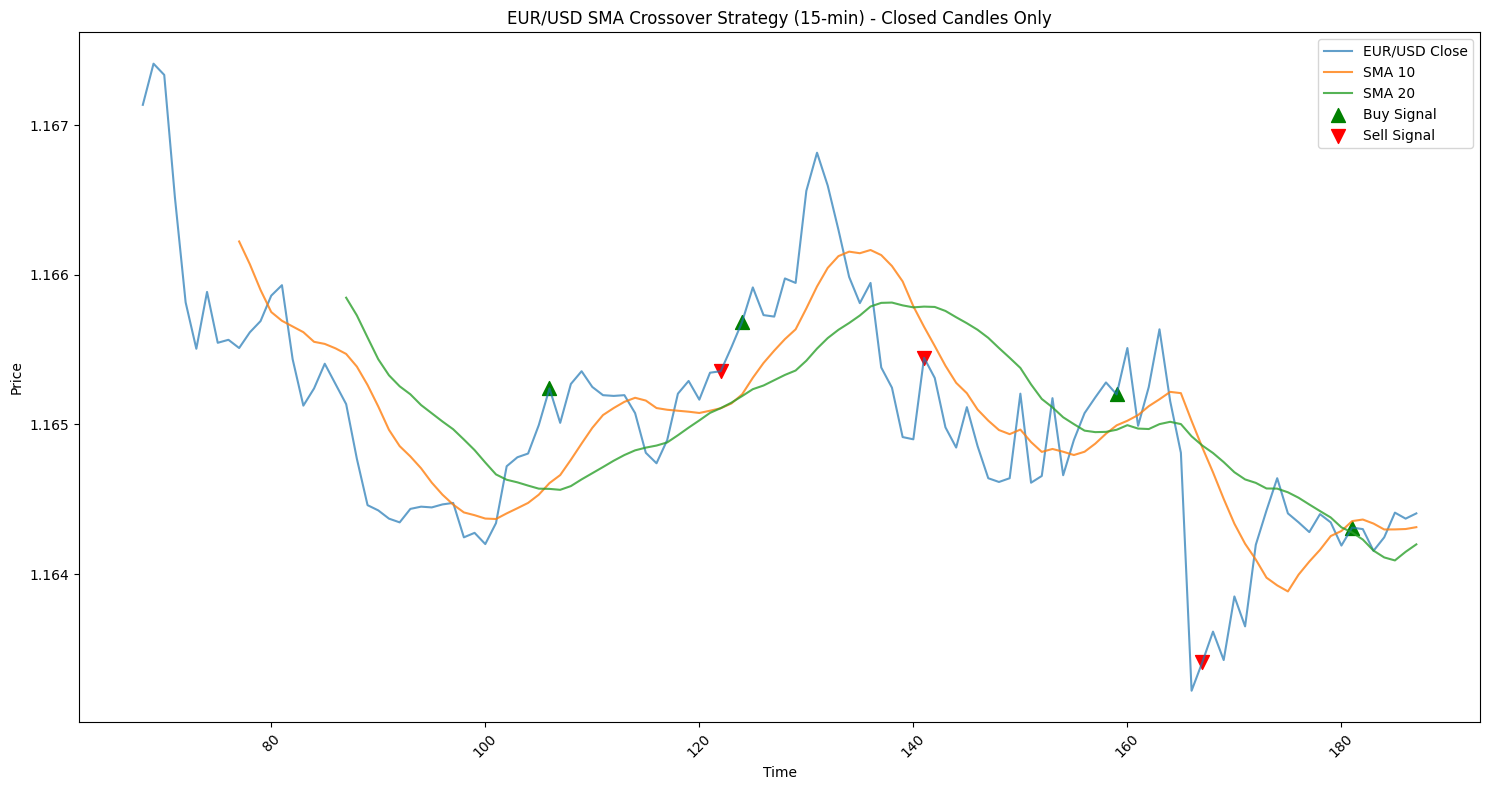

In [19]:
# 3.5. Calculate signals and plot strategy
# Calculate initial signals for plotting
df_signals = calculate_sma_signals_with_atr(df)
print(f"Buy signals: {df_signals['buy_signal'].sum()}")
print(f"Sell signals: {df_signals['sell_signal'].sum()}")

# Plot the strategy
plt.figure(figsize=(15, 8))
plt.plot(df_signals.index, df_signals['close'], label='EUR/USD Close', alpha=0.7)
plt.plot(df_signals.index, df_signals['SMA_short'], label='SMA 10', alpha=0.8)
plt.plot(df_signals.index, df_signals['SMA_long'], label='SMA 20', alpha=0.8)

# Mark buy/sell signals
buy_points = df_signals[df_signals['buy_signal']]
sell_points = df_signals[df_signals['sell_signal']]
plt.scatter(buy_points.index, buy_points['close'], color='green', marker='^', s=100, label='Buy Signal')
plt.scatter(sell_points.index, sell_points['close'], color='red', marker='v', s=100, label='Sell Signal')

plt.legend()
plt.title('EUR/USD SMA Crossover Strategy (15-min) - Closed Candles Only')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# 4. Trading System Configuration - ATR-BASED RISK MANAGEMENT
class TradingSystem:
    def __init__(self, ib, contract, position_size=1000, atr_sl_multiplier=1.5, atr_tp_multiplier=3.0):
        self.ib = ib
        self.contract = contract
        self.position_size = position_size
        self.atr_sl_multiplier = atr_sl_multiplier
        self.atr_tp_multiplier = atr_tp_multiplier
        self.pip_value = 0.0001

        self.trades = []
        self.current_position = None
        self.account_balance = 10000
        self.balance_history = [self.account_balance]

    def get_current_price(self):
        """Get current market price"""
        ticker = self.ib.reqMktData(self.contract, '', False, False)
        self.ib.sleep(1)
        price = (ticker.bid + ticker.ask) / 2 if ticker.bid and ticker.ask else ticker.last
        self.ib.cancelMktData(self.contract)
        return price

    def calculate_atr_stop_take_levels(self, entry_price, action, atr_value):
        """Calculate stop loss and take profit based on ATR"""
        stop_loss_amount = atr_value * self.atr_sl_multiplier
        take_profit_amount = atr_value * self.atr_tp_multiplier
        
        if action == 'BUY':
            stop_loss = entry_price - stop_loss_amount
            take_profit = entry_price + take_profit_amount
        else:  # SELL
            stop_loss = entry_price + stop_loss_amount
            take_profit = entry_price - take_profit_amount
        
        return stop_loss, take_profit

    def execute_trade_on_next_bar_open(self, signal_type, open_price, execution_time, atr_value):
        """Execute trade using ATR for risk management"""
        if self.current_position is not None:
            return False

        action = 'BUY' if signal_type == 'buy' else 'SELL'
        stop_loss, take_profit = self.calculate_atr_stop_take_levels(open_price, action, atr_value)
        
        self.current_position = {
            'action': action,
            'entry_price': open_price,
            'quantity': self.position_size,
            'stop_loss': stop_loss,
            'take_profit': take_profit,
            'entry_time': execution_time
        }
        
        print(f"Opened {action} position at {open_price:.5f} (ATR: {atr_value:.5f})")
        print(f"Stop Loss: {stop_loss:.5f}, Take Profit: {take_profit:.5f}")
        return True

    def check_exit_conditions(self, high_price, low_price):
        """Check if position should be closed"""
        if self.current_position is None:
            return False, None, None
        
        pos = self.current_position
        if pos['action'] == 'BUY':
            if low_price <= pos['stop_loss']:
                return True, pos['stop_loss'], 'Stop Loss'
            elif high_price >= pos['take_profit']:
                return True, pos['take_profit'], 'Take Profit'
        else:  # SELL
            if high_price >= pos['stop_loss']:
                return True, pos['stop_loss'], 'Stop Loss'
            elif low_price <= pos['take_profit']:
                return True, pos['take_profit'], 'Take Profit'
        
        return False, None, None

    def close_position(self, exit_price, exit_reason, exit_time):
        """Close current position and record trade"""
        if self.current_position is None:
            return
        
        pos = self.current_position
        pnl_pips = ((exit_price - pos['entry_price']) / self.pip_value) if pos['action'] == 'BUY' else ((pos['entry_price'] - exit_price) / self.pip_value)
        pnl_usd = pnl_pips * self.pip_value * pos['quantity']
        
        trade_record = {
            'entry_time': pos['entry_time'], 'exit_time': exit_time, 'action': pos['action'],
            'entry_price': pos['entry_price'], 'exit_price': exit_price, 'quantity': pos['quantity'],
            'pnl_pips': pnl_pips, 'pnl_usd': pnl_usd, 'exit_reason': exit_reason
        }
        
        self.trades.append(trade_record)
        self.account_balance += pnl_usd
        self.balance_history.append(self.account_balance)
        
        print(f"Closed {pos['action']} position at {exit_price:.5f}")
        print(f"P&L: {pnl_pips:.1f} pips (${pnl_usd:.2f}) - {exit_reason}")
        self.current_position = None

# Initialize trading system with ATR multipliers
trading_system = TradingSystem(ib, contract, atr_sl_multiplier=1.5, atr_tp_multiplier=3.0)
print("Trading system initialized with ATR-based risk management")
print(f"Position size: {trading_system.position_size} units")
print(f"Stop Loss: {trading_system.atr_sl_multiplier} x ATR")
print(f"Take Profit: {trading_system.atr_tp_multiplier} x ATR")

Trading system initialized with ATR-based risk management
Position size: 1000 units
Stop Loss: 1.5 x ATR
Take Profit: 3.0 x ATR


In [21]:
# 5. Simulate Trading - ATR-BASED
def backtest_strategy_closed_bars(df_signals, trading_system):
    """
    Backtest strategy using closed bars for signals and ATR for risk.
    """
    trades_executed = 0
    
    # Start from bar 22 to ensure we have enough data for indicators
    for i in range(22, len(df_signals)):
        signal_data = df_signals.iloc[:i]
        
        current_bar = df_signals.iloc[i]
        current_open = current_bar['open']
        current_high = current_bar['high']
        current_low = current_bar['low']
        current_time = current_bar['date']
        
        if trading_system.current_position is not None:
            should_exit, exit_price, exit_reason = trading_system.check_exit_conditions(
                current_high, current_low
            )
            if should_exit:
                trading_system.close_position(exit_price, exit_reason, current_time)
        
        if trading_system.current_position is None:
            signal, atr_value = check_for_signals(signal_data)
            
            if signal is not None and atr_value is not None:
                success = trading_system.execute_trade_on_next_bar_open(
                    signal, current_open, current_time, atr_value
                )
                if success:
                    trades_executed += 1
    
    if trading_system.current_position is not None:
        trading_system.close_position(
            df_signals.iloc[-1]['close'], 
            'End of Data', 
            df_signals.iloc[-1]['date']
        )
    
    print(f"Backtest completed. Trades executed: {trades_executed}")
    print(f"Trades closed: {len(trading_system.trades)}")
    
    return trading_system.trades

# Run backtest with ATR-based risk
trades = backtest_strategy_closed_bars(df_signals, trading_system)
trades_df = pd.DataFrame(trades)

if not trades_df.empty:
    print("\nFirst 5 trades:")
    print(trades_df.head())
else:
    print("No trades were completed in the backtest period.")

Opened BUY position at 1.16501 (ATR: 0.00021)
Stop Loss: 1.16470, Take Profit: 1.16563
Closed BUY position at 1.16470
P&L: -3.1 pips ($-0.31) - Stop Loss
Opened SELL position at 1.16552 (ATR: 0.00025)
Stop Loss: 1.16589, Take Profit: 1.16477
Closed SELL position at 1.16589
P&L: -3.8 pips ($-0.38) - Stop Loss
Opened BUY position at 1.16592 (ATR: 0.00025)
Stop Loss: 1.16554, Take Profit: 1.16666
Closed BUY position at 1.16554
P&L: -3.7 pips ($-0.37) - Stop Loss
Opened SELL position at 1.16531 (ATR: 0.00054)
Stop Loss: 1.16613, Take Profit: 1.16368
Closed SELL position at 1.16368
P&L: 16.3 pips ($1.63) - Take Profit
Opened SELL position at 1.16362 (ATR: 0.00084)
Stop Loss: 1.16488, Take Profit: 1.16109
Closed SELL position at 1.16440
P&L: -7.9 pips ($-0.79) - End of Data
Backtest completed. Trades executed: 5
Trades closed: 5

First 5 trades:
                 entry_time                 exit_time action  entry_price  \
0 2025-12-05 01:30:00+00:00 2025-12-05 03:30:00+00:00    BUY     1.1650

In [22]:
# 6. Performance Analysis
def analyze_performance(trades_df, trading_system):
    """Analyze trading performance and calculate key metrics"""
    if len(trades_df) == 0:
        print("No trades to analyze.")
        return
    
    # Basic metrics
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['pnl_usd'] > 0])
    losing_trades = len(trades_df[trades_df['pnl_usd'] < 0])
    
    # Win rate
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
    
    # P&L metrics
    total_pnl = trades_df['pnl_usd'].sum()
    avg_trade_pnl = trades_df['pnl_usd'].mean()
    avg_winner = trades_df[trades_df['pnl_usd'] > 0]['pnl_usd'].mean() if winning_trades > 0 else 0
    avg_loser = trades_df[trades_df['pnl_usd'] < 0]['pnl_usd'].mean() if losing_trades > 0 else 0
    
    # Calculate maximum drawdown
    balance_series = pd.Series(trading_system.balance_history)
    cumulative_max = balance_series.expanding().max()
    drawdown = (balance_series - cumulative_max) / cumulative_max * 100
    max_drawdown = drawdown.min()
    
    # Calculate Sharpe ratio (simplified)
    if len(trades_df) > 1:
        returns = trades_df['pnl_usd'] / 10000  # Assuming $10k account
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    else:
        sharpe_ratio = 0
    
    # Profit factor
    gross_profit = trades_df[trades_df['pnl_usd'] > 0]['pnl_usd'].sum()
    gross_loss = abs(trades_df[trades_df['pnl_usd'] < 0]['pnl_usd'].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
    
    print("= * 50")
    print("PERFORMANCE ANALYSIS RESULTS")
    print("= * 50")
    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {winning_trades}")
    print(f"Losing Trades: {losing_trades}")
    print(f"Win Rate: {win_rate:.1f}%")
    print()
    print("P&L METRICS:")
    print(f"Total P&L: ${total_pnl:.2f}")
    print(f"Average Trade P&L: ${avg_trade_pnl:.2f}")
    print(f"Average Winner: ${avg_winner:.2f}")
    print(f"Average Loser: ${avg_loser:.2f}")
    print(f"Profit Factor: {profit_factor:.2f}")
    print()
    print("RISK METRICS:")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Final Account Balance: ${trading_system.account_balance:.2f}")
    
    return {
        'total_trades': total_trades,
        'win_rate': win_rate,
        'total_pnl': total_pnl,
        'avg_trade_pnl': avg_trade_pnl,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio,
        'profit_factor': profit_factor
    }

# Analyze performance
performance_metrics = analyze_performance(trades_df, trading_system)

= * 50
PERFORMANCE ANALYSIS RESULTS
= * 50
Total Trades: 5
Winning Trades: 1
Losing Trades: 4
Win Rate: 20.0%

P&L METRICS:
Total P&L: $-0.22
Average Trade P&L: $-0.04
Average Winner: $1.63
Average Loser: $-0.46
Profit Factor: 0.88

RISK METRICS:
Maximum Drawdown: -0.01%
Sharpe Ratio: -0.73
Final Account Balance: $9999.78


In [23]:
# 8. Real-time Trading - USING CLOSED CANDLES ONLY
def real_time_monitor():
    """Monitor for crossover signals in real-time using ONLY closed bars"""
    print("Starting real-time monitoring (closed bars only)")
    print("Press Ctrl+C to stop")
    
    try:
        while True:
            # Get fresh data
            current_data = get_historical_data(contract, 120)
            
            # Check for signals using ONLY closed bars (iloc[-2])
            signal, atr_value = check_for_signals(current_data)
            
            # Get current price for position monitoring
            current_price = trading_system.get_current_price()
            
            if current_price is None:
                print("Could not get current price")
                time.sleep(60)
                continue
            
            print(f"Time: {datetime.now().strftime('%H:%M:%S')} | Price: {current_price:.5f} | Position: {trading_system.current_position is not None}")
            
            # Check exit conditions using current price as approximation
            if trading_system.current_position is not None:
                # In real-time, we approximate high/low with current price
                should_exit, exit_price, exit_reason = trading_system.check_exit_conditions(
                    current_price, current_price
                )
                
                if should_exit:
                    # Use actual current price for exit
                    trading_system.close_position(current_price, exit_reason, datetime.now())
            
            # Check for new signals using ONLY closed bars
            if signal is not None and atr_value is not None and trading_system.current_position is None:
                # In real-time, we execute immediately at current price
                trading_system.execute_trade_on_next_bar_open(signal, current_price, datetime.now(), atr_value)
                print(f"Signal detected: {signal.upper()}")
            
            time.sleep(60)  # Check every minute
            
    except KeyboardInterrupt:
        print("\nReal-time monitoring stopped.")
        if trading_system.current_position is not None:
            current_price = trading_system.get_current_price()
            if current_price:
                trading_system.close_position(current_price, 'Manual Stop', datetime.now())

print("Real-time monitoring function ready (closed bars only).")
print("To start real-time monitoring, call: real_time_monitor()")
print("WARNING: This will place actual trades if connected to a live account!")

Real-time monitoring function ready (closed bars only).
To start real-time monitoring, call: real_time_monitor()


In [25]:
# 9. Disconnect from IB
print("Disconnecting from Interactive Brokers...")
ib.disconnect()
print("Disconnected successfully.")

Disconnecting from Interactive Brokers...
Disconnected successfully.


## Challenge Summary

### What We've Implemented:
1. **Instrument Selection**: EUR/USD forex pair (high liquidity)
2. **Timeframe**: 15-minute bars for balanced noise/signal ratio
3. **Strategy**: SMA crossover (10 vs 20 period)
4. **Risk Management**: ATR-based stop-loss (1.5 x ATR), take-profit (3 x ATR)
5. **Position Sizing**: 1000 units (adjustable)
6. **Performance Analysis**: Complete metrics including Sharpe ratio

### Key Features:
- ✅ Historical backtesting
- ✅ Real-time signal detection
- ✅ Automated dynamic risk management
- ✅ Performance visualization
- ✅ Trade statistics and analysis

**Remember**: This is for educational purposes. Always test thoroughly before risking real money!